# Time-Domain Simulation of a Joined-Wing

In this example we use the same joined-wing model as used in the [previous example](@ref
static-joined-wing), but with the following time varying loads applied at the wingtip:
 - A piecewise-linear load $F_L$ in the x and y-directions defined as follows:
$$
F_L(t) = \begin{cases}
    t10^6 \text{ N} & 0 \leq t \leq 0.01 \\
    (0.02-t)10^6 & 0.01 \leq t \leq 0.02 \\
    0 & \text{otherwise}
\end{cases}
$$
- A sinusoidal load $F_S$ applied in the z-direction defined as follows:
$$
F_S(t) = \begin{cases}
    0 & t \lt 0 \\
    5 \times 10^3 (1-\cos(\pi t /0.02)) \text{ N} & 0 \leq t \lt 0.02 \\
    10^4 \text{ N} & 0.02 \leq t
\end{cases}
$$

We will also use the same compliance and mass matrix for all beams, in order to simplify
the problem definition.

![](../assets/static-joined-wing-drawing.png)

In [1]:
using GXBeam, LinearAlgebra

# Set endpoints of each beam
p1 = [0, 0, 0]
p2 = [-7.1726, -12, -3.21539]
p3 = [7.1726, -12,  3.21539]

Cab_1 = [
0.5         0.866025  0.0
0.836516    -0.482963  0.258819
0.224144     -0.12941   -0.965926
]

Cab_2 = [
0.5         0.866025  0.0
-0.836516    0.482963 0.258819
0.224144    -0.12941   0.965926
]

# beam 1
L_b1 = norm(p1-p2)
r_b1 = p2
nelem_b1 = 8
lengths_b1, xp_b1, xm_b1, Cab_b1 = discretize_beam(L_b1, r_b1, nelem_b1, frame=Cab_1)

# beam 2
L_b2 = norm(p3-p1)
r_b2 = p1
nelem_b2 = 8
lengths_b2, xp_b2, xm_b2, Cab_b2 = discretize_beam(L_b2, r_b2, nelem_b2, frame=Cab_2)

# combine elements and points into one array
nelem = nelem_b1 + nelem_b2
points = vcat(xp_b1, xp_b2[2:end])
start = 1:nelem
stop = 2:nelem + 1
lengths = vcat(lengths_b1, lengths_b2)
midpoints = vcat(xm_b1, xm_b2)
Cab = vcat(Cab_b1, Cab_b2)

# assign all beams the same compliance and mass matrix
compliance = fill(Diagonal([2.93944738387698e-10, 8.42991725049126e-10,
    3.38313996669689e-08, 4.69246721094557e-08, 6.79584100559513e-08,
    1.37068861370898e-09]), nelem)
mass = fill(Diagonal([4.86e-2, 4.86e-2, 4.86e-2, 1.0632465e-2, 2.10195e-4,
    1.042227e-2]), nelem)

# create assembly
assembly = Assembly(points, start, stop;
    compliance = compliance,
    mass = mass,
    frames = Cab,
    lengths = lengths,
    midpoints = midpoints)

F_L = (t) -> begin
    if 0.0 <= t < 0.01
        1e6*t
    elseif 0.01 <= t < 0.02
        -1e6*(t-0.02)
    else
        zero(t)
    end
end

F_S = (t) -> begin
    if t < 0.0
        zero(t)
    elseif 0.0 <= t < 0.02
        5e3*(1-cos(pi*t/0.02))
    else
        1e4
    end
end

# assign boundary conditions and point load
prescribed_conditions = (t) -> begin
    Dict(
        # fixed endpoint on beam 1
        1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0),
        # force applied on point 4
        nelem_b1 + 1 => PrescribedConditions(Fx=F_L(t), Fy=F_L(t), Fz=F_S(t)),
        # fixed endpoint on last beam
        nelem+1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0),
    )
end

# time
t = range(0, 0.04, length=1001)

system, history, converged = time_domain_analysis(assembly, t;
    prescribed_conditions=prescribed_conditions)

nothing #hide

We can visualize tip displacements and the resultant forces accessing the post-processed
results for each time step contained in the variable `history`.  Note that the fore-root
and rear-root resultant forces for this case are equal to the external forces/moments,
but with opposite sign.

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


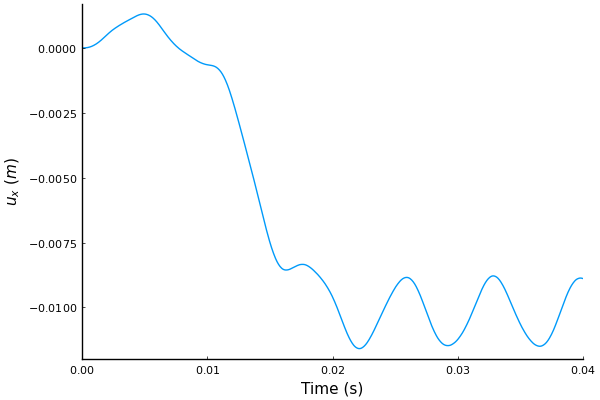

In [2]:
using Plots
pyplot()

point = vcat(fill(nelem_b1+1, 6), fill(1, 6))
field = [:u, :u, :u, :theta, :theta, :theta, :F, :F, :F, :M, :M, :M]
direction = [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]
ylabel = ["\$u_x\$ (\$m\$)", "\$u_y\$ (\$m\$)", "\$u_z\$ (\$m\$)",
    "Rodriguez Parameter \$\\theta_x\$", "Rodriguez Parameter \$\\theta_y\$",
    "Rodriguez Parameter \$\\theta_z\$", "\$F_x\$ at the forewing root (\$N\$)",
    "\$F_y\$ at the forewing root (\$N\$)", "\$F_z\$ at the forewing root (\$N\$)",
    "\$M_x\$ at the forewing root (\$Nm\$)", "\$M_y\$ at the forewing root (\$Nm\$)",
    "\$M_z\$ at the forewing root (\$N\$)"]
ph = Vector{Any}(undef, 12)

for i = 1:12
    ph[i] = plot(
        xlim = (0, 0.04),
        xticks = 0:0.01:0.04,
        xlabel = "Time (s)",
        ylabel = ylabel[i],
        grid = false,
        overwrite_figure=false
        )
    y = [getproperty(state.points[point[i]], field[i])[direction[i]] for state in history]

    if field[i] == :theta
        # convert to angle
        @. y = 4*atan(y/4)
    end

    if field[i] == :F || field[i] == :M
        y = -y
    end

    plot!(t, y, label="")
end

ph[1]

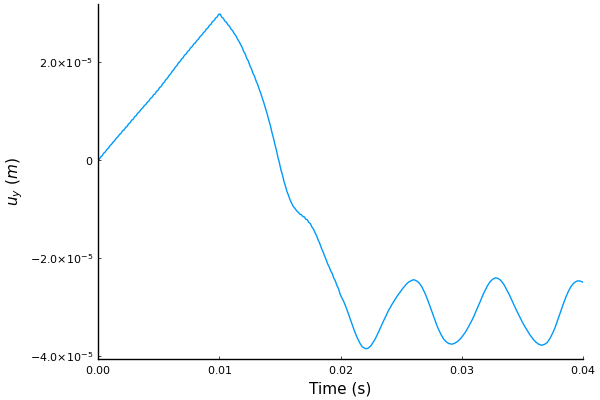

In [3]:
ph[2]

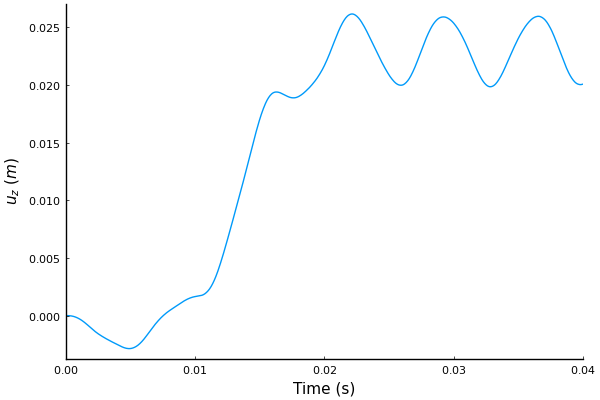

In [4]:
ph[3]

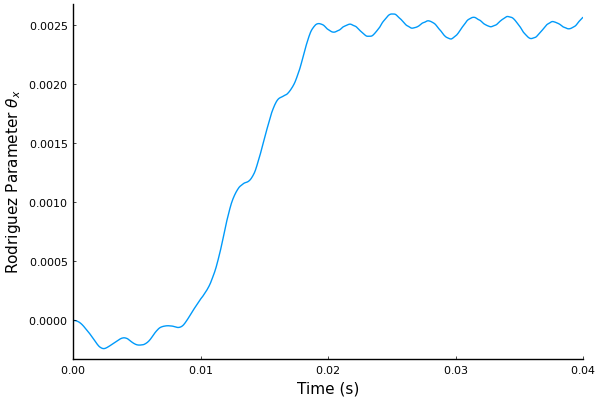

In [5]:
ph[4]

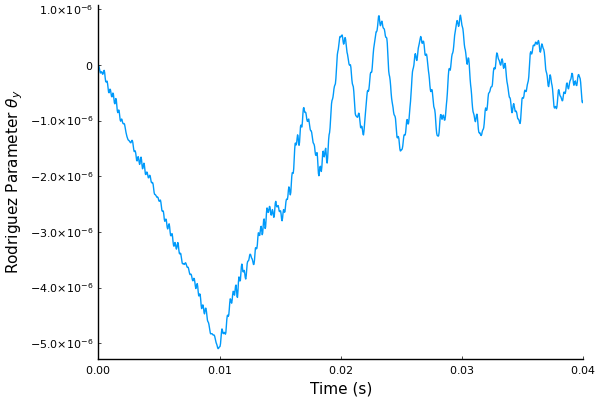

In [6]:
ph[5]

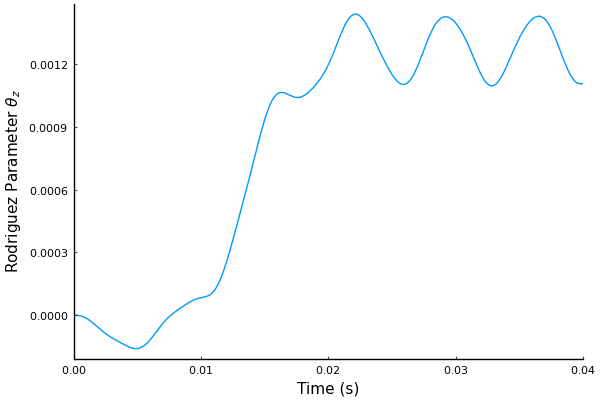

In [7]:
ph[6]

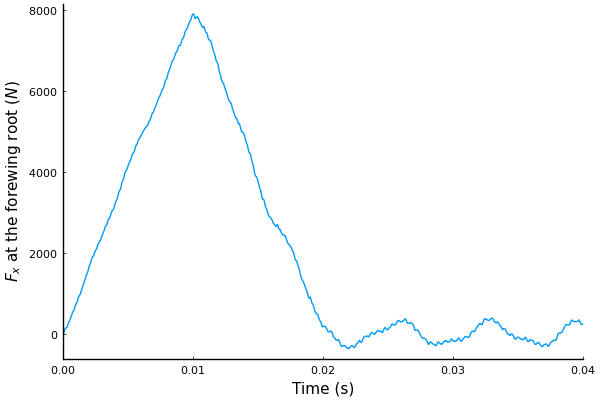

In [8]:
ph[7]

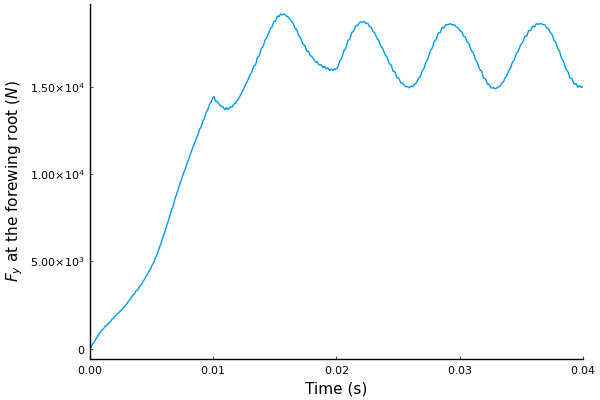

In [9]:
ph[8]

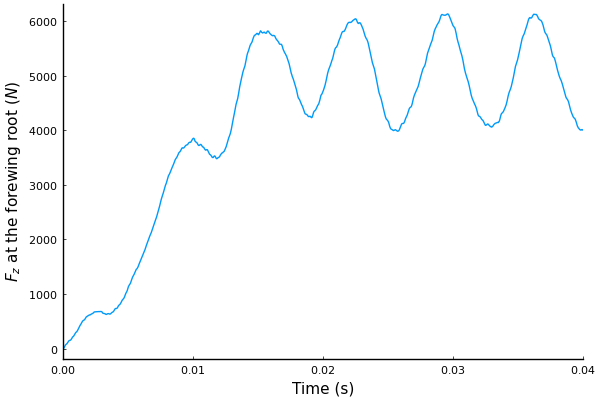

In [10]:
ph[9]

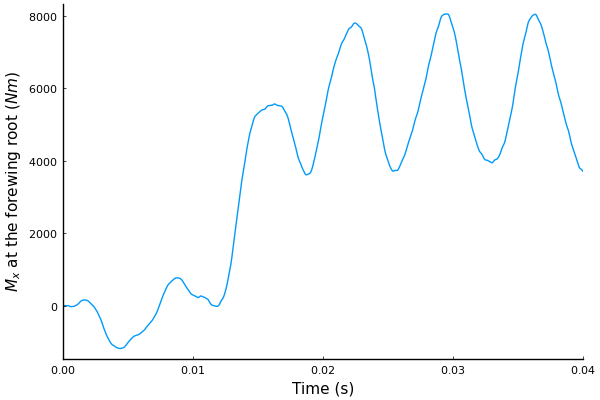

In [11]:
ph[10]

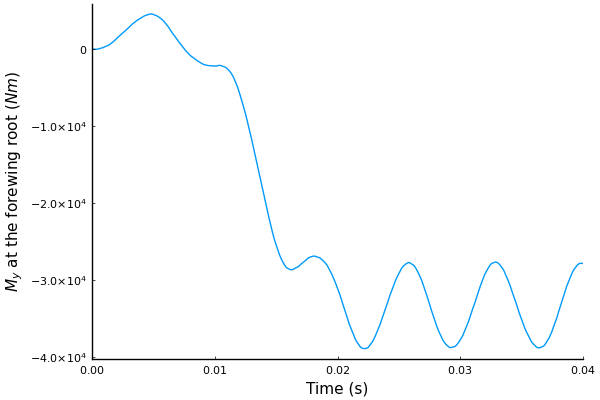

In [12]:
ph[11]

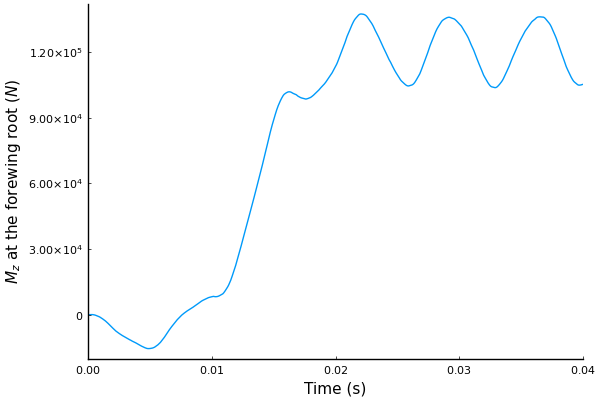

In [13]:
ph[12]

These graphs are identical to those presented in "GEBT: A general-purpose nonlinear analysis tool for composite beams" by Wenbin Yu and Maxwell Blair.

We can also visualize the time history of the system using ParaView.  In order to view the small deflections we'll scale all the deflections up by a couple orders of magnitude.  We'll also set the color gradient to match the magnitude of the deflections at each point.

In [14]:
airfoil  = [ #FX 60-100 airfoil
    0.0000000 0.0000000;
    0.0010700 0.0057400;
    0.0042800 0.0114400;
    0.0096100 0.0177500;
    0.0170400 0.0236800;
    0.0265300 0.0294800;
    0.0380600 0.0352300;
    0.0515600 0.0405600;
    0.0669900 0.0460900;
    0.0842700 0.0508600;
    0.1033200 0.0556900;
    0.1240800 0.0598900;
    0.1464500 0.0640400;
    0.1703300 0.0675400;
    0.1956200 0.0708100;
    0.2222100 0.0733900;
    0.2500000 0.0756500;
    0.2788600 0.0772000;
    0.3086600 0.0783800;
    0.3392800 0.0788800;
    0.3705900 0.0789800;
    0.4024500 0.0784500;
    0.4347400 0.0775000;
    0.4673000 0.0759600;
    0.5000000 0.0740900;
    0.5327000 0.0717400;
    0.5652600 0.0691100;
    0.5975500 0.0660800;
    0.6294100 0.0627500;
    0.6607200 0.0590500;
    0.6913400 0.0551100;
    0.7211400 0.0508900;
    0.7500000 0.0465200;
    0.7777900 0.0420000;
    0.8043801 0.0374700;
    0.8296700 0.0329800;
    0.8535500 0.0286400;
    0.8759201 0.0244700;
    0.8966800 0.0205300;
    0.9157300 0.0168100;
    0.9330100 0.0134200;
    0.9484400 0.0103500;
    0.9619400 0.0076600;
    0.9734700 0.0053400;
    0.9829600 0.0034100;
    0.9903900 0.0019300;
    0.9957200 0.0008600;
    0.9989300 0.0002300;
    1.0000000 0.0000000;
    0.9989300 0.0001500;
    0.9957200 0.0007000;
    0.9903900 0.0015100;
    0.9829600 0.00251;
    0.9734700 0.00377;
    0.9619400 0.00515;
    0.9484400 0.00659;
    0.9330100 0.00802;
    0.9157300 0.00941;
    0.8966800 0.01072;
    0.8759201 0.01186;
    0.8535500 0.0128;
    0.8296700 0.01347;
    0.8043801 0.01381;
    0.7777900 0.01373;
    0.7500000 0.01329;
    0.7211400 0.01241;
    0.6913400 0.01118;
    0.6607200 0.00951;
    0.6294100 0.00748;
    0.5975500 0.00496;
    0.5652600 0.00217;
    0.532700  -0.00092;
    0.500000  -0.00405;
    0.467300  -0.00731;
    0.434740  -0.01045;
    0.402450  -0.01357;
    0.370590  -0.01637;
    0.339280  -0.01895;
    0.308660  -0.021;
    0.278860  -0.02275;
    0.250000  -0.02389;
    0.222210  -0.02475;
    0.195620  -0.025;
    0.170330  -0.02503;
    0.146450  -0.02447;
    0.124080  -0.02377;
    0.103320  -0.02246;
    0.084270  -0.0211;
    0.066990  -0.01913;
    0.051560  -0.0173;
    0.038060  -0.01481;
    0.026530  -0.01247;
    0.017040  -0.0097;
    0.009610  -0.00691;
    0.004280  -0.00436;
    0.001070  -0.002;
    0.0        0.0;
]

section = zeros(3, size(airfoil, 1))
for ic = 1:size(airfoil, 1)
    section[1,ic] = airfoil[ic,1] - 0.5
    section[2,ic] = 0
    section[3,ic] = airfoil[ic,2]
end

write_vtk("dynamic-joined-wing-simulation", assembly, history, t, scaling=1e2;
    sections = section)

![](../assets/dynamic-joined-wing-simulation.gif)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*